In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sympy
import numpy as np
import torch
torch.manual_seed(12)
torch.cuda.manual_seed(12)
torch.cuda.manual_seed_all

dtype = torch.float
device = torch.device("cuda:0")


In [2]:
import sys

In [3]:
sys.path.append('/u/wangnisn/devel/machine_learning_kinetics/ml_kinetics')

In [4]:
from mlk import learning

# Set up model

In [5]:
vortex = {'eqn_type':'vortex',
        'fcn':'exp(-1/2*(x-cos(t))**2-1/2*(y-sin(t))**2)',
        'domain':{'x':[-2,2],'y':[-2,2],'t':[0,2]},
        
        'err_vec':[0,0,0,1,-1,0,0]}

u_t,u_x,u_y,u,x,y = sympy.symbols('u_t u_x u_y u x y')

dictionary = (u_x,u_y,x*u_x,y*u_x,x*u_y,y*u_y,u)
vortex['dictionary'] = dictionary
pde = vortex
domain =pde['domain']
fcn = pde['fcn']
n_points = 50000
x = sympy.symbols([x for x in domain.keys()])
u_exact = sympy.lambdify(x,sympy.sympify(fcn),'numpy')
inputs = {}
for key in domain.keys():
    min_d = domain[key][0]
    max_d = domain[key][1]
    #iputs[key] = ((max_d-min_d)*torch.rand((n_points,1),device=device,dtype=dtype,requires_grad=True)+min_d)
    tt = np.random.uniform(min_d,max_d,(n_points,1))
    inputs[key] = torch.tensor(tt,device=device,dtype=dtype,requires_grad=True)
u_exact = sympy.lambdify(x,sympy.sympify(fcn),'numpy')
u = u_exact(*[i.detach().cpu() for i in inputs.values()])
pde = {}
u = u.type(dtype).to(device)
pde['inputs'] = inputs

In [6]:
params = {'n_epochs':10000,
          'alpha_pde_start':1,
           'alpha_pde_end':50,
           'alpha_l1':1e-5, 
          'warmup_nsteps':500,
          'linearRegInterval':5,
          'linearRegression':True,
          'width':50,
          'layers':8,
          'lr':0.002,
          'update_coef_in_dl':False,
          'logfile':'alpha_increase.txt'}

model = learning(inputs=inputs, u=u, dictionary=dictionary,**params)


Epoch:    0,  Loss u: 1.381e-01, Loss pde: 9.823e-04, Loss_norm: 7.488e+00, Loss tot: 1.381e-01
  coefs: -5.6304e-01   -2.8970e+00    1.4370e-01   -6.2471e-01   -1.4866e+00    1.3500e+00    4.2288e-01  
Epoch:   50,  Loss u: 1.569e-02, Loss pde: 3.447e-01, Loss_norm: 7.488e+00, Loss tot: 1.569e-02
  coefs: -5.6304e-01   -2.8970e+00    1.4370e-01   -6.2471e-01   -1.4866e+00    1.3500e+00    4.2288e-01  
Epoch:  100,  Loss u: 2.240e-03, Loss pde: 9.350e-01, Loss_norm: 7.488e+00, Loss tot: 2.240e-03
  coefs: -5.6304e-01   -2.8970e+00    1.4370e-01   -6.2471e-01   -1.4866e+00    1.3500e+00    4.2288e-01  
Epoch:  150,  Loss u: 1.366e-03, Loss pde: 9.511e-01, Loss_norm: 7.488e+00, Loss tot: 1.366e-03
  coefs: -5.6304e-01   -2.8970e+00    1.4370e-01   -6.2471e-01   -1.4866e+00    1.3500e+00    4.2288e-01  
Epoch:  200,  Loss u: 9.115e-04, Loss pde: 9.027e-01, Loss_norm: 7.488e+00, Loss tot: 9.115e-04
  coefs: -5.6304e-01   -2.8970e+00    1.4370e-01   -6.2471e-01   -1.4866e+00    1.3500e+00  

Epoch: 2050,  Loss u: 4.092e-04, Loss pde: 8.313e-06, Loss_norm: 1.665e+00, Loss tot: 5.176e-04
  coefs:  3.4611e-01   -2.5420e-01   -9.8414e-05    5.3306e-01   -5.2947e-01   -6.1419e-04   -1.1337e-03  
Epoch: 2100,  Loss u: 3.658e-04, Loss pde: 7.619e-06, Loss_norm: 1.682e+00, Loss tot: 4.686e-04
  coefs:  3.4180e-01   -2.4296e-01   -3.2468e-07    5.4815e-01   -5.4662e-01   -1.6175e-03   -5.4789e-04  
Epoch: 2150,  Loss u: 3.482e-04, Loss pde: 7.661e-06, Loss_norm: 1.688e+00, Loss tot: 4.535e-04
  coefs:  3.5067e-01   -2.2323e-01   -4.4123e-04    5.5159e-01   -5.5592e-01   -4.3628e-03   -1.8605e-03  
Epoch: 2200,  Loss u: 7.175e-04, Loss pde: 3.311e-05, Loss_norm: 1.713e+00, Loss tot: 1.125e-03
  coefs:  3.5916e-01   -2.2684e-01   -3.4106e-03    5.5664e-01   -5.6537e-01    1.2136e-04   -1.8902e-03  
Epoch: 2250,  Loss u: 3.444e-04, Loss pde: 8.454e-06, Loss_norm: 1.724e+00, Loss tot: 4.634e-04
  coefs:  3.7012e-01   -2.0979e-01   -1.7735e-03    5.6347e-01   -5.7395e-01   -3.2029e-03  

Epoch: 4100,  Loss u: 2.292e-04, Loss pde: 1.685e-06, Loss_norm: 1.783e+00, Loss tot: 2.825e-04
  coefs:  2.5537e-01   -1.1077e-01   -0.0000e+00    7.1516e-01   -7.0029e-01   -1.6846e-03   -0.0000e+00  
Epoch: 4150,  Loss u: 2.071e-04, Loss pde: 1.558e-06, Loss_norm: 1.785e+00, Loss tot: 2.582e-04
  coefs:  2.4721e-01   -1.1664e-01   -0.0000e+00    7.1493e-01   -7.0395e-01   -2.2002e-03    1.9750e-05  
Epoch: 4200,  Loss u: 2.023e-04, Loss pde: 1.722e-06, Loss_norm: 1.816e+00, Loss tot: 2.577e-04
  coefs:  2.5747e-01   -1.2339e-01    1.0417e-03    7.2060e-01   -7.0933e-01   -3.5173e-03    3.3583e-04  
Epoch: 4250,  Loss u: 1.850e-04, Loss pde: 1.638e-06, Loss_norm: 1.814e+00, Loss tot: 2.389e-04
  coefs:  2.5444e-01   -1.2640e-01   -8.8694e-04    7.2054e-01   -7.1025e-01   -1.2538e-03    2.9729e-04  
Epoch: 4300,  Loss u: 2.333e-04, Loss pde: 2.191e-06, Loss_norm: 1.828e+00, Loss tot: 3.000e-04
  coefs:  2.6812e-01   -1.1758e-01   -1.5547e-03    7.2501e-01   -7.1068e-01   -5.4476e-03  

Epoch: 6150,  Loss u: 1.515e-04, Loss pde: 1.064e-06, Loss_norm: 1.824e+00, Loss tot: 2.029e-04
  coefs:  2.4040e-01   -1.3790e-01   -1.6835e-03    7.1203e-01   -7.3090e-01   -3.5981e-04    8.9188e-04  
Epoch: 6200,  Loss u: 1.493e-04, Loss pde: 7.951e-07, Loss_norm: 1.834e+00, Loss tot: 1.926e-04
  coefs:  2.4866e-01   -1.3685e-01   -2.1396e-03    7.1400e-01   -7.3114e-01   -0.0000e+00    1.2199e-03  
Epoch: 6250,  Loss u: 1.553e-04, Loss pde: 7.917e-07, Loss_norm: 1.837e+00, Loss tot: 1.987e-04
  coefs:  2.5463e-01   -1.3321e-01   -2.2124e-03    7.1533e-01   -7.2990e-01   -0.0000e+00    1.2425e-03  
Epoch: 6300,  Loss u: 1.707e-04, Loss pde: 8.119e-07, Loss_norm: 1.823e+00, Loss tot: 2.148e-04
  coefs:  2.5314e-01   -1.2477e-01   -3.2170e-03    7.1539e-01   -7.2556e-01   -0.0000e+00    7.8680e-04  
Epoch: 6350,  Loss u: 1.574e-04, Loss pde: 7.216e-07, Loss_norm: 1.817e+00, Loss tot: 1.988e-04
  coefs:  2.4590e-01   -1.3034e-01   -1.1472e-03    7.1233e-01   -7.2561e-01   -0.0000e+00  

Epoch: 8200,  Loss u: 1.709e-04, Loss pde: 4.627e-07, Loss_norm: 1.812e+00, Loss tot: 2.081e-04
  coefs:  2.7103e-01   -1.5666e-01   -1.8557e-03    6.7843e-01   -6.9893e-01    0.0000e+00    5.3340e-03  
Epoch: 8250,  Loss u: 1.694e-04, Loss pde: 4.326e-07, Loss_norm: 1.820e+00, Loss tot: 2.055e-04
  coefs:  2.7395e-01   -1.6120e-01   -1.1693e-03    6.7741e-01   -7.0060e-01   -0.0000e+00    6.0509e-03  
Epoch: 8300,  Loss u: 1.678e-04, Loss pde: 4.194e-07, Loss_norm: 1.823e+00, Loss tot: 2.035e-04
  coefs:  2.7536e-01   -1.6369e-01   -7.8900e-04    6.7708e-01   -7.0079e-01   -0.0000e+00    5.5945e-03  
Epoch: 8350,  Loss u: 1.718e-04, Loss pde: 4.676e-07, Loss_norm: 1.811e+00, Loss tot: 2.095e-04
  coefs:  2.6994e-01   -1.6246e-01   -3.4688e-04    6.7510e-01   -6.9833e-01    6.9502e-07    4.7960e-03  
Epoch: 8400,  Loss u: 1.684e-04, Loss pde: 4.134e-07, Loss_norm: 1.817e+00, Loss tot: 2.039e-04
  coefs:  2.7200e-01   -1.6688e-01   -1.9084e-04    6.7319e-01   -6.9981e-01   -0.0000e+00  

In [5]:
log = pd.read_csv('alpha_increase.txt')

In [6]:
log['p3'].values

array([-0.62471, -0.62471, -0.62471, ...,  0.63449,  0.63449,  0.63449])

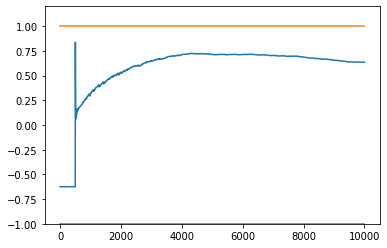

In [7]:
plt.plot(log['Epoch'].values, log['p3'].values)
plt.plot([0,10000],[1,1])
plt.ylim(-1,1.2)
plt.plot([0,10000],[-1,-1])

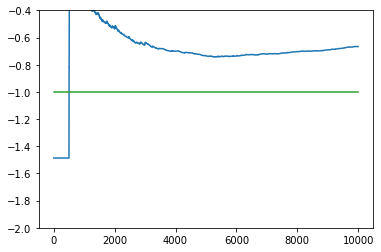

In [8]:
plt.plot(log['Epoch'], log['p4'])
plt.plot([0,10000],[1,1])
plt.ylim(-2,-0.4)
plt.plot([0,10000],[-1,-1])

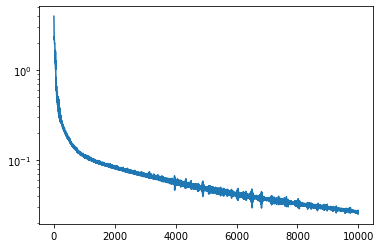

In [213]:
plt.semilogy(stat['epoch'], stat['loss_u'])

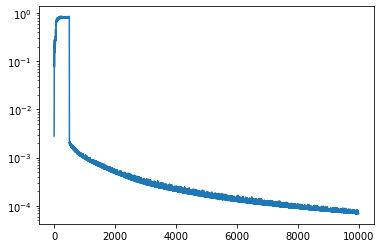

In [214]:
plt.semilogy(stat['epoch'], stat['loss_f'])

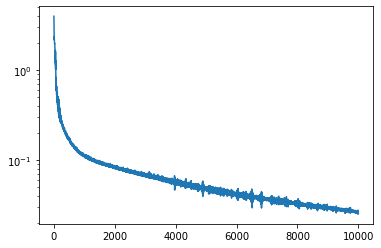

In [215]:
plt.semilogy(stat['epoch'], stat['loss_tot'])

In [10]:
t_mesh = dt*np.arange(nsteps)
x_mesh = dx*np.arange(nx)
y_mesh = dy*np.arange(ny)
t_mesh, x_mesh,y_mesh = np.meshgrid(t_mesh, x_mesh, y_mesh,indexing='ij')
t_mesh = np.reshape(t_mesh, (-1,1))
x_mesh = np.reshape(x_mesh, (-1,1))
y_mesh = np.reshape(y_mesh, (-1,1))
x_mesh /= x_max
y_mesh /= y_max
t_mesh /= t_max
prediction = model(torch.cat([torch.tensor(x_mesh), torch.tensor(y_mesh), torch.tensor(t_mesh)],dim=1).double().cuda(0))